In [1]:
import os
import sys

!pip install opencv-python
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

You should consider upgrading via the 'C:\Users\sarat\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Загрузка и предобработка данных

Для загрузки и обработки данных мы испрользовали библиотеку OpenCV. Для обработки использовался алгоритм [Histograms Equalization](https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html) что уменьшает весь картинок переводя из RGB в моно, а также выравнивает распределение цветов на изображении.

In [3]:
def fill_df(df, path, files, covid_test):
    for f in files:
        p = path + f
        img = cv.imread(p)
        df = df.append({'image':img, 'path':p, 'covid':covid_test}, ignore_index=True)
    return df

In [4]:
def fill_and_compute_df(df, path, files, covid_test):
    for f in files:
        p = path + f
        img = cv.imread(p)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        equ = cv.equalizeHist(img)
        df = df.append({'image':equ, 'path':p, 'covid':covid_test}, ignore_index=True)
    return df

In [5]:
curr_path = os.path.abspath(os.getcwd())
cov_path  = curr_path[:-22] + 'COVID/'
norm_path = curr_path[:-22] + 'NORMAL/'

In [6]:
cov_files  = os.listdir(cov_path)
norm_files = os.listdir(norm_path)

In [7]:
df = pd.DataFrame(columns = ['image', 'path', 'covid'])

In [8]:
df = fill_and_compute_df(df, cov_path, cov_files, 1)
df = fill_and_compute_df(df, norm_path, norm_files, 0)

In [9]:
df.head()

,image,path,covid
0,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...",F:\iad\COVID/covid_0.jpg,1
1,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,...",F:\iad\COVID/covid_1.jpg,1
2,"[[14, 12, 12, 8, 12, 12, 8, 8, 5, 8, 12, 12, 1...",F:\iad\COVID/covid_10.jpg,1
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",F:\iad\COVID/covid_100.jpg,1
4,"[[25, 25, 25, 25, 25, 24, 24, 24, 24, 24, 24, ...",F:\iad\COVID/covid_101.jpg,1


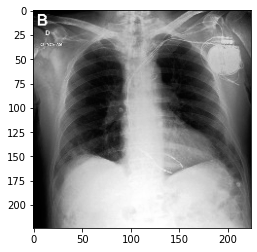

In [10]:
plt.imshow(df['image'][1], cmap='gray')

In [11]:
df.describe()

,image,path,covid
count,324,324,324
unique,324,324,2
top,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...",F:\iad\COVID/covid_0.jpg,1
freq,1,1,162


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   324 non-null    object
 1   path    324 non-null    object
 2   covid   324 non-null    object
dtypes: object(3)
memory usage: 7.7+ KB


# Разбиение и работа с моделями

In [28]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms
import seaborn as sn

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [25]:
def train_model(model, epochs, criterion, optimizer, X_train, Y_train, X_test, Y_test):
    losses = []
    accs = []
    for i in range(epochs):
        i += 1
        Y_pred = model.forward(X_train)
        loss = criterion(Y_pred, Y_train)
        losses.append(loss)
        acc = test_model(model, X_test, Y_test, 0)
        accs.append(acc)
        print(f'epoch: {i:2}  loss: {loss.item():10.8f} acc: {acc}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return model, accs, losses

In [15]:
def test_model(model, X_test, Y_test, show):
    counter = 0
    y_test_len = len(Y_test)

    with torch.no_grad():
        for i,data in enumerate(X_test):
            y_val = model.forward(data)
            if y_val.argmax().item() == Y_test[i]:
                counter += 1
    res = 100*counter/y_test_len
    if show:
        print(f'{counter} out of {y_test_len} = {res}% right')
    else:
        return res

In [30]:
# так как работа связана с медициной то используем confusion_matrix
def test_res_model(model, X_test, Y_test, show, target_names):
    pr = []
    with torch.no_grad():
        for i,data in enumerate(X_test):
            y_val = model.forward(data)
            res = y_val.argmax().item()
            pr.append(res)
    res = confusion_matrix(Y_test, pr)
    if show:
        df_cm = pd.DataFrame(res)
        plt.figure(figsize = (4,4))
        sn.heatmap(df_cm, annot=True, xticklabels=target_names, yticklabels=target_names)
    else:
        return res

In [17]:
data_copy = df.copy()

In [18]:
data_split = data_copy.copy()

y = data_split['covid'].values
x = data_split['image'].values

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3)

In [20]:
X_train = [np.hstack(image).astype(np.float32) for image in X_train]

In [21]:
X_test = [np.hstack(image).astype(np.float32) for image in X_test]

In [22]:
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
Y_train_tensor = torch.tensor(list(Y_train))
Y_test_tensor = torch.tensor(list(Y_test))

In [37]:
target_names = ["norm", "covid"]

# Работа с моделями

### Модель 1

In [23]:
model1 = nn.Sequential(
    nn.Linear(224 * 224, 224),
    nn.ReLU(),
    nn.Linear(224, 16),
    nn.ReLU(),
    nn.Linear(16, 4),
    nn.ReLU(),    
    nn.Linear(4, 2),
    nn.Sigmoid())

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)

In [26]:
epochs1 = 20
model1_, accs1, losses1  = train_model(model1, epochs1, criterion, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor)

epoch:  1  loss: 0.71714824 acc: 39.795918367346935
epoch:  2  loss: 0.69314730 acc: 40.816326530612244
epoch:  3  loss: 0.69314730 acc: 40.816326530612244
epoch:  4  loss: 0.69314730 acc: 40.816326530612244
epoch:  5  loss: 0.69314730 acc: 40.816326530612244
epoch:  6  loss: 0.69314730 acc: 40.816326530612244
epoch:  7  loss: 0.69314730 acc: 40.816326530612244
epoch:  8  loss: 0.69314730 acc: 40.816326530612244
epoch:  9  loss: 0.69314730 acc: 40.816326530612244
epoch: 10  loss: 0.69314730 acc: 40.816326530612244
epoch: 11  loss: 0.69314730 acc: 40.816326530612244
epoch: 12  loss: 0.69314730 acc: 40.816326530612244
epoch: 13  loss: 0.69314730 acc: 40.816326530612244
epoch: 14  loss: 0.69314730 acc: 40.816326530612244
epoch: 15  loss: 0.69314730 acc: 40.816326530612244
epoch: 16  loss: 0.69314730 acc: 40.816326530612244
epoch: 17  loss: 0.69314730 acc: 40.816326530612244
epoch: 18  loss: 0.69314730 acc: 40.816326530612244
epoch: 19  loss: 0.69314730 acc: 40.816326530612244
epoch: 20  l

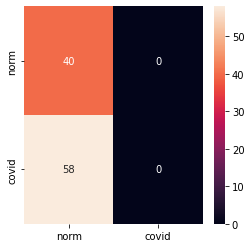

In [38]:
test_res_model(model1_, X_test_tensor, Y_test_tensor, 1, target_names)

### Модель 2

In [32]:
input_size = 224 * 224
hidden_sizes = [283, 43, 32, 5, 2]
output_size = 2
print(hidden_sizes)

[283, 43, 32, 5, 2]


In [33]:
model2 = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[3], hidden_sizes[4]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[4], output_size))

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)

In [36]:
epochs2 = 20
model2_, accs2, losses2 = train_model(model2, epochs2, criterion, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor)

epoch:  1  loss: 0.79272974 acc: 59.183673469387756
epoch:  2  loss: 23.43014336 acc: 59.183673469387756
epoch:  3  loss: 0.72789222 acc: 59.183673469387756
epoch:  4  loss: 0.72558391 acc: 59.183673469387756
epoch:  5  loss: 0.72346580 acc: 59.183673469387756
epoch:  6  loss: 0.72148246 acc: 59.183673469387756
epoch:  7  loss: 0.71960521 acc: 59.183673469387756
epoch:  8  loss: 0.71781802 acc: 59.183673469387756
epoch:  9  loss: 0.71611089 acc: 59.183673469387756
epoch: 10  loss: 0.71447808 acc: 59.183673469387756
epoch: 11  loss: 0.71291500 acc: 59.183673469387756
epoch: 12  loss: 0.71141905 acc: 59.183673469387756
epoch: 13  loss: 0.70998752 acc: 59.183673469387756
epoch: 14  loss: 0.70861953 acc: 59.183673469387756
epoch: 15  loss: 0.70731318 acc: 59.183673469387756
epoch: 16  loss: 0.70606774 acc: 59.183673469387756
epoch: 17  loss: 0.70488191 acc: 59.183673469387756
epoch: 18  loss: 0.70375472 acc: 59.183673469387756
epoch: 19  loss: 0.70268518 acc: 59.183673469387756
epoch: 20  

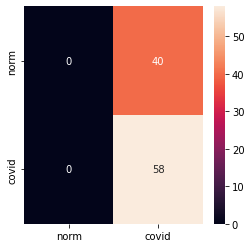

In [39]:
test_res_model(model2_, X_test_tensor, Y_test_tensor, 1, target_names)

### Модель 3

In [40]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.fc1 = nn.Linear(224 * 224, 224)
        self.fc2 = nn.Linear(224, 112)
        self.fc3 = nn.Linear(112, 56)
        self.fc4 = nn.Linear(56, 28)
        self.fc5 = nn.Linear(28, 14)
        self.fc6 = nn.Linear(14, 7)
        self.fc7 = nn.Linear(7, 2)
    
    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = F.selu(self.fc4(x))
        x = F.selu(self.fc5(x))
        x = F.celu(self.fc6(x))
        x = F.celu(self.fc7(x))
        return x

In [41]:
model3 = Model3()

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)

In [43]:
epochs3 = 20
model3_, accs3, losses3 = train_model(model3, epochs3, criterion, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor)

epoch:  1  loss: 0.77776778 acc: 40.816326530612244
epoch:  2  loss: 276.47387695 acc: 59.183673469387756
epoch:  3  loss: 69.65414429 acc: 40.816326530612244
epoch:  4  loss: 1254.72875977 acc: 40.816326530612244
epoch:  5  loss: 511.95492554 acc: 59.183673469387756
epoch:  6  loss: 248.68582153 acc: 59.183673469387756
epoch:  7  loss: 85.80082703 acc: 40.816326530612244
epoch:  8  loss: 0.69314730 acc: 40.816326530612244
epoch:  9  loss: 0.69314730 acc: 40.816326530612244
epoch: 10  loss: 0.69314730 acc: 40.816326530612244
epoch: 11  loss: 0.69314730 acc: 40.816326530612244
epoch: 12  loss: 0.69314730 acc: 40.816326530612244
epoch: 13  loss: 0.69314730 acc: 40.816326530612244
epoch: 14  loss: 0.69314730 acc: 40.816326530612244
epoch: 15  loss: 0.69314730 acc: 40.816326530612244
epoch: 16  loss: 0.69314730 acc: 40.816326530612244
epoch: 17  loss: 0.69314730 acc: 40.816326530612244
epoch: 18  loss: 0.69314730 acc: 40.816326530612244
epoch: 19  loss: 0.69314730 acc: 40.816326530612244
e

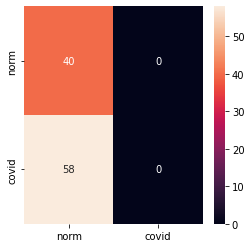

In [44]:
test_res_model(model3_, X_test_tensor, Y_test_tensor, 1, target_names)

### Модель 4

In [45]:
class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()
        self.fc1 = nn.Linear(224 * 224, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 250)
        self.fc4 = nn.Linear(250, 125)
        self.fc5 = nn.Linear(125, 62)
        self.fc6 = nn.Linear(62, 31)
        self.fc7 = nn.Linear(31, 15)
        self.fc8 = nn.Linear(15, 2)
    
    def forward(self, x):
        x = F.hardtanh(self.fc1(x))
        x = F.hardtanh(self.fc2(x))
        x = F.hardtanh(self.fc3(x))
        x = F.gelu(self.fc4(x))
        x = F.gelu(self.fc5(x))
        x = F.gelu(self.fc6(x))
        x = F.relu6(self.fc7(x))
        x = F.relu6(self.fc8(x))
        return F.log_softmax(x)

In [46]:
model4 = Model4()

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=0.01)

In [49]:
epochs4 = 20
model4_, accs4, losses4 = train_model(model4, epochs4, criterion, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor)

epoch:  1  loss: 0.69222581 acc: 40.816326530612244
epoch:  2  loss: 0.69144964 acc: 40.816326530612244
epoch:  3  loss: 0.69028461 acc: 40.816326530612244
epoch:  4  loss: 0.72723079 acc: 40.816326530612244
epoch:  5  loss: 0.68997228 acc: 40.816326530612244
epoch:  6  loss: 0.69023216 acc: 40.816326530612244
epoch:  7  loss: 0.69021541 acc: 40.816326530612244
epoch:  8  loss: 0.69006443 acc: 40.816326530612244
epoch:  9  loss: 0.68998551 acc: 40.816326530612244
epoch: 10  loss: 0.69005167 acc: 40.816326530612244
epoch: 11  loss: 0.69019264 acc: 40.816326530612244
epoch: 12  loss: 0.68997324 acc: 40.816326530612244
epoch: 13  loss: 0.69009030 acc: 40.816326530612244
epoch: 14  loss: 0.68997461 acc: 40.816326530612244
epoch: 15  loss: 0.69007224 acc: 40.816326530612244
epoch: 16  loss: 0.68997550 acc: 40.816326530612244
epoch: 17  loss: 0.69006723 acc: 40.816326530612244
epoch: 18  loss: 0.68997508 acc: 40.816326530612244
epoch: 19  loss: 0.69004619 acc: 40.816326530612244
epoch: 20  l

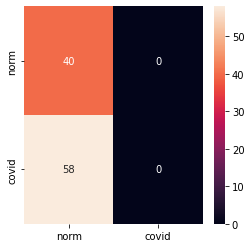

In [50]:
test_res_model(model4_, X_test_tensor, Y_test_tensor, 1, target_names)

# Результаты

In [51]:
max_epoch = max(epochs1, epochs2, epochs3, epochs4)
x = list(range(1, max_epoch+1))
print(x)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [52]:
accs1_ = accs1 + [np.nan for i in range(max_epoch-len(accs1))]
accs2_ = accs2 + [np.nan for i in range(max_epoch-len(accs2))]
accs3_ = accs3 + [np.nan for i in range(max_epoch-len(accs3))]
accs4_ = accs4 + [np.nan for i in range(max_epoch-len(accs4))]

In [53]:
losses1_ = [i.item() for i in losses1] + [np.nan for i in range(max_epoch-len(losses1))]
losses2_ = [i.item() for i in losses2] + [np.nan for i in range(max_epoch-len(losses2))]
losses3_ = [i.item() for i in losses3] + [np.nan for i in range(max_epoch-len(losses3))]
losses4_ = [i.item() for i in losses4] + [np.nan for i in range(max_epoch-len(losses4))]

In [54]:
df_accs_plot = pd.DataFrame({
    'model_1': accs1_,
    'model_2': accs2_,
    'model_3': accs3_,
    'model_4': accs4_,
}, index=x)

In [55]:
df_losses_plot = pd.DataFrame({
    'model_1': losses1_,
    'model_2': losses2_,
    'model_3': losses3_,
    'model_4': losses4_,
}, index=x)

<AxesSubplot:>

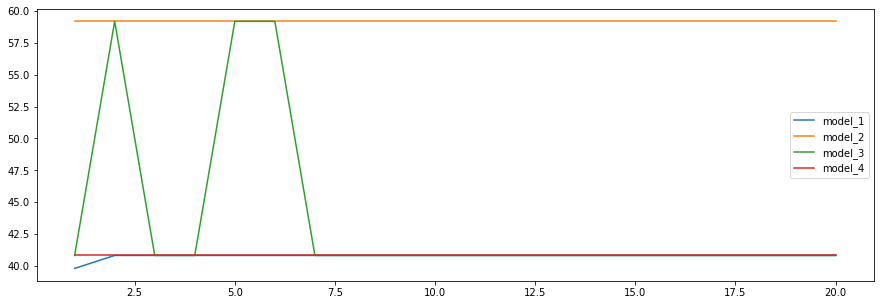

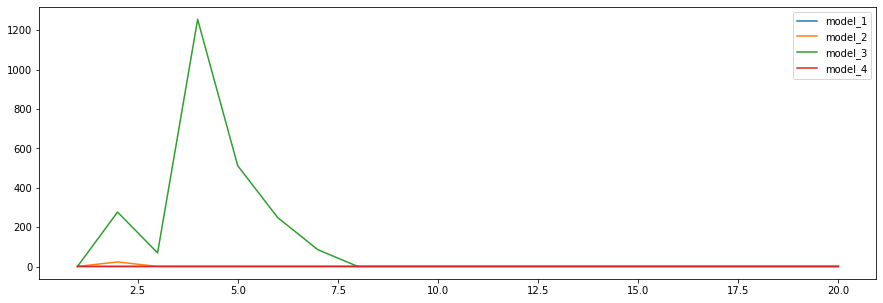

In [56]:
df_accs_plot.plot(figsize=(15, 5))
df_losses_plot.plot(figsize=(15, 5))

# Вывод